In [1]:
# Import packages
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import os

from astropy.cosmology import FlatLambdaCDM

# load the relevant modules from the light package
import light.catalog.catalog as catalog_module
import light.utils.conventions as conventions

hist_kwargs = {'bins': 'auto', 'histtype': 'step', 'density': True}

The following cell loads the raw catalog data as a pandas frame. This can be replaced by 
your favourite method of loading data.

In [2]:
galaxies_percentage, box_size = 0.01, 150
catalog_origin = 'millenium'
catalog_file_name_original = f'{catalog_origin}_bertone2007a_{galaxies_percentage}_{box_size}Mpc.csv'

# load the catalog df
catalog_df = catalog_module.load_catalog_df(
    catalog_origin=catalog_origin,
    catalog_file_name_original=catalog_file_name_original,
    data_folder='~/Documents/cosmology/galaxy_catalogs/galaxy_completion/gaussian_toy_model/data/millenium/'
)
display(catalog_df)

keys in catalog:  ['mag_k', 'x', 'y', 'z']


,M,X,Y,Z
0,-20.152613,131.721650,143.559190,97.969170
1,-18.564243,5.194337,145.237730,36.397175
2,-19.909857,97.665184,137.542710,29.376240
3,-16.995457,123.944900,135.301440,65.761080
4,-16.365507,142.252370,142.454480,3.630022
...,...,...,...,...
5834,-13.312079,47.381800,14.720333,86.351010
5835,-15.561258,39.822468,17.876850,87.939964
5836,-16.320375,55.682290,82.127570,67.329765
5837,-18.288815,7.835886,84.063220,84.343070


This converts the catalog df in the different files that are relevant for the analysis, namely a list of the magnitudes, the list of redshifts, the number counts in each voxel etc. 

The cell after this cell serve for plotting or demonstrate other options, such as 
- Selected pixels with an increased magnitude threshold or 
- Redshift uncertainties

In [3]:
Z_offset, redshift_num_bins, m_threshold = 300, 10, 17
pixel_length = box_size / redshift_num_bins
cosmology = FlatLambdaCDM(H0=73, Om0=0.25, Ob0=0.05)

catalog = catalog_module.SimulatedCatalog(
    catalog=catalog_df,
    pixel_length_in_Mpc_comoving=[pixel_length, pixel_length, pixel_length],
    m_threshold=m_threshold,
    cosmology=cosmology,
    galaxies_percentage=galaxies_percentage,
    Z_offset=Z_offset,
    zmax=2,
    pixelation='redshift',
    redshift_num_bins=redshift_num_bins,
    box_size_d=[box_size,box_size,box_size],
    redshift_error_settings={},
)

output_path = f'./my_data/'
os.makedirs(output_path, exist_ok=True)
catalog.save_matrices(output_path)


Computing redshifts ...
Minimum and maximum comoving distance: 300.01, 449.86
Added redshifts.
z_min = 0.07 and z_max = 0.11 for the redshift grid
Binning truth by ['X_bin', 'Y_bin', 'z_bin']
Binning observed survey by ['X_bin', 'Y_bin', 'z_bin']
Passed sanity check. 


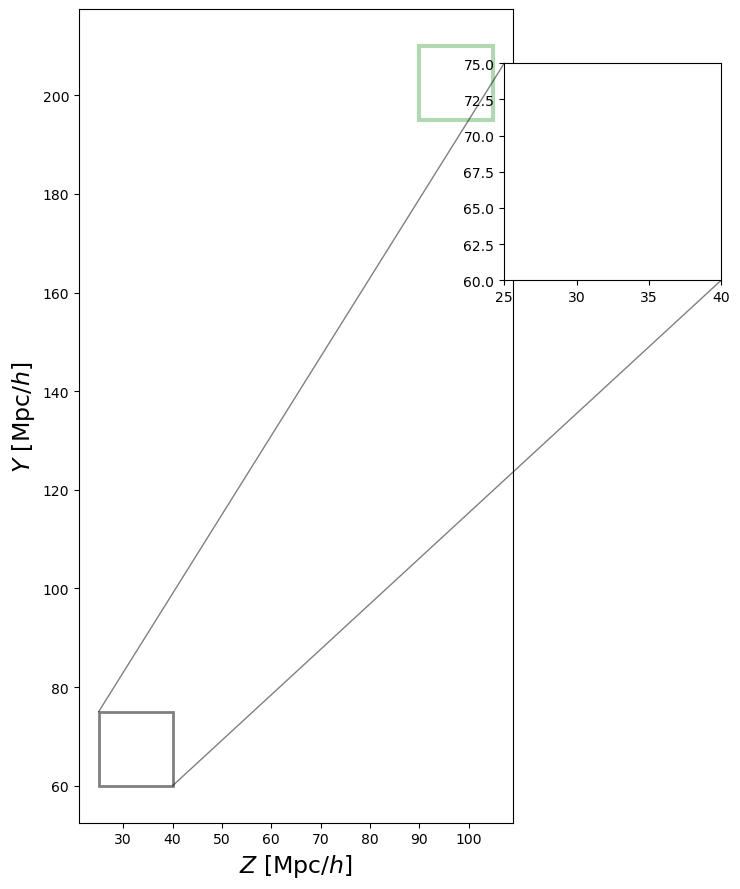

In [4]:
plot_kwargs = {'fontsize': 17}

fig, ax = plt.subplots(figsize=(15, 9))

idx_X_slice = catalog.catalog['X_bin'] == 25
y_values = catalog.catalog['Z'][idx_X_slice]
z_values = catalog.catalog['Y'][idx_X_slice]

# Create a scatter plot
red_scatter = ax.scatter(y_values, z_values, alpha=0.6, s=0.1, c='red')
ax.set_xlabel(r'$Z$ [Mpc/$h$]', **plot_kwargs)
ax.set_ylabel(r'$Y$ [Mpc/$h$]', **plot_kwargs)

# Create the inset plot
selected_catalog = catalog.catalog[idx_X_slice]
idx_Y, idx_Z = 13, 6
idx = (selected_catalog['Y_bin'] == idx_Y) * (selected_catalog['Z_bin'] == idx_Z)
selected_catalog = selected_catalog[idx]
blue_scatter = ax.scatter(selected_catalog['Z'], selected_catalog['Y'], alpha=0.6, s=1, c='blue')

# Determine the boundaries of the rectangle
pixel_length = catalog.pixel_length_in_Mpc_comoving[2]
min_y, max_y = idx_Y * pixel_length, (idx_Y + 1) * pixel_length 
min_z, max_z = idx_Z * pixel_length, (idx_Z + 1) * pixel_length 

# Create the transparent rectangle
rect = patches.Rectangle((min_z, min_y), max_z - min_z, max_y - min_y, linewidth=3, edgecolor='green', facecolor='none', alpha=0.3)
ax.add_patch(rect)

axins = ax.inset_axes([0.98, 0.55, 0.5, 0.5])
axins.scatter(z_values, y_values, alpha=1, s=4, c='red')
axins.scatter(selected_catalog['Z'], selected_catalog['Y'], alpha=1, s=4, c='blue')
axins.set_xlim(25, 40)
axins.set_ylim(60, 75)


rect = patches.Rectangle((min_z, min_y), max_z - min_z, max_y - min_y, linewidth=4.2, edgecolor='green', facecolor='none', alpha=0.3)
axins.add_patch(rect)
ax.indicate_inset_zoom(axins, lw=2, edgecolor="black")

# Save the figure
ax.set_aspect('equal', adjustable='box')
axins.set_aspect('equal', adjustable='box')
plt.tight_layout()
# fig.savefig('./plots/catalog_example_with_inset.png')

plt.show()


In [5]:
from matplotlib.colors import LogNorm
class ShiftedLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, clip=True, epsilon=1e-5, value_epsilon=0):
        self.epsilon = epsilon
        self.value_epsilon = value_epsilon

        if(vmin is not None):
            vmin = max(vmin, epsilon) # Ensure vmin is at least epsilon

        super().__init__(vmin=vmin, vmax=vmax, clip=clip)
    
    def __call__(self, value, clip=None):
        """
        Shift the input data by epsilon before applying LogNorm.
        """
        shifted_value = value + self.value_epsilon
        return super().__call__(shifted_value, clip)

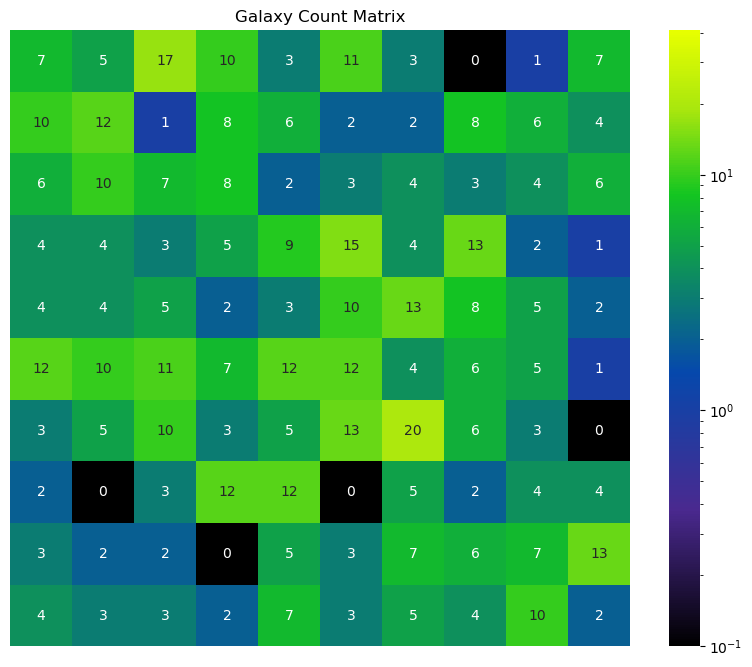

In [6]:
idx_X = 6
matrix = catalog.matrix_bin_counts.to_numpy().reshape(catalog.box_shape_d)[idx_X]
            
# Plotting the color matrix
plt.figure(figsize=(10, 8))
norm = ShiftedLogNorm(**dict(vmin=0, vmax=np.percentile(catalog.matrix_bin_counts.max(), 100), epsilon=1e-1))
sns.heatmap(np.flip(matrix, axis = (0)), annot=True, fmt='g', cmap=conventions.custom_cmap, norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('Galaxy Count Matrix')
plt.show()

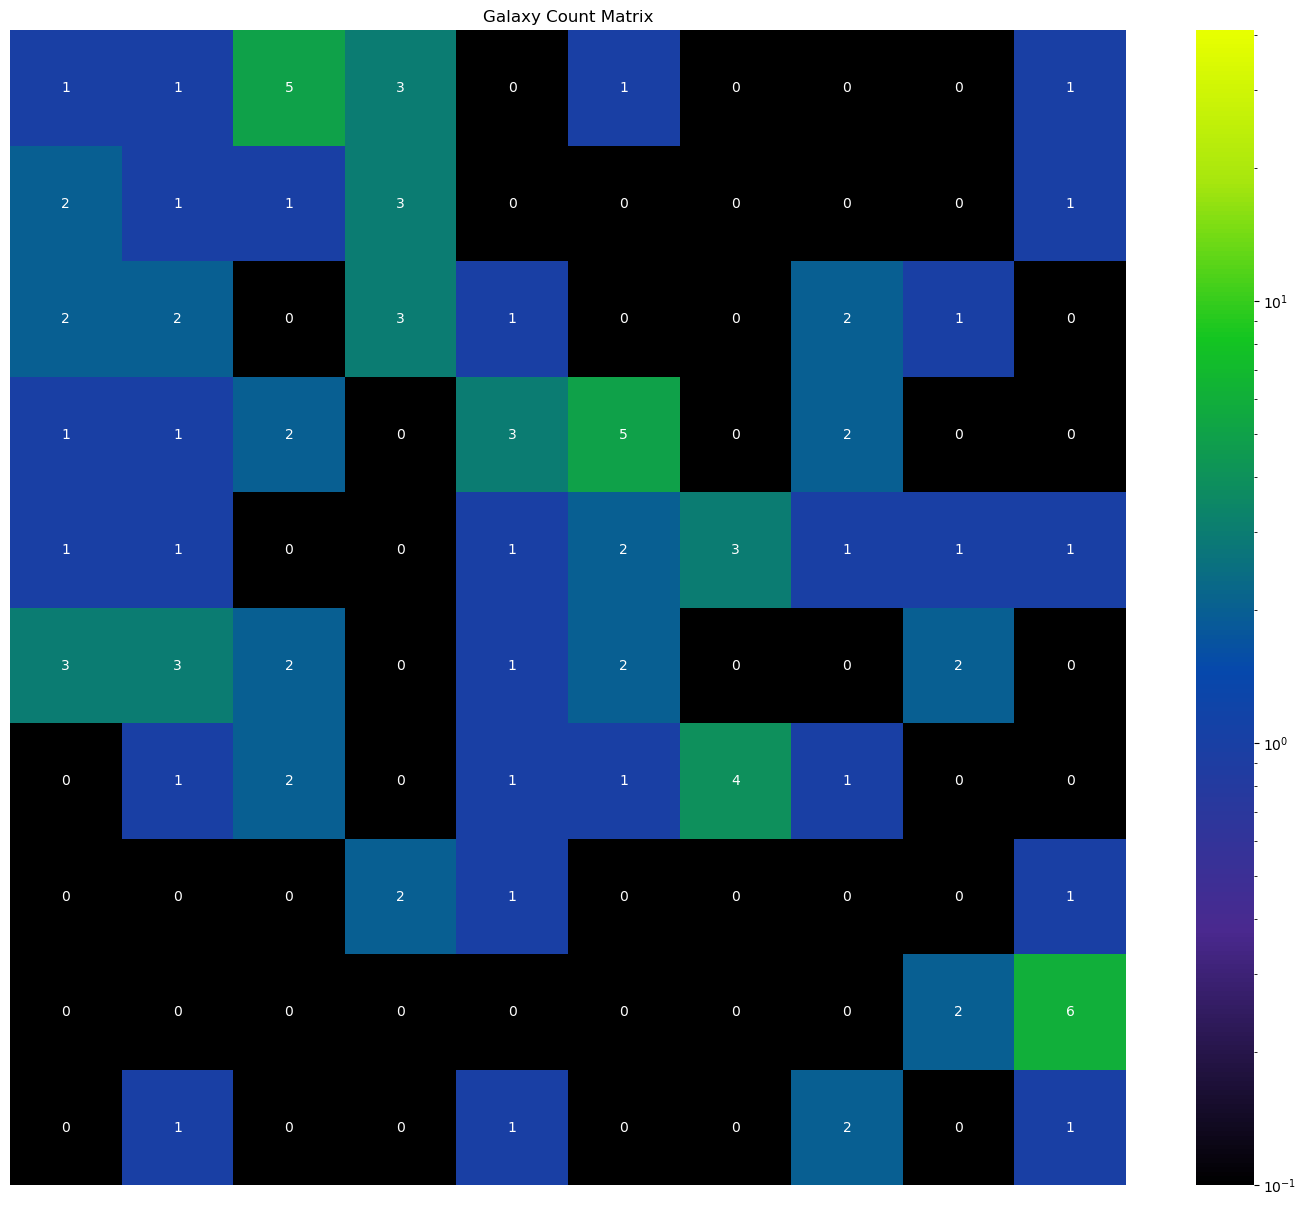

In [7]:
matrix = catalog.matrix_bin_counts_obs.to_numpy().reshape(catalog.box_shape_d)[idx_X]

# Plotting the color matrix
plt.figure(figsize=(18, 15))
norm = ShiftedLogNorm(**dict(vmin=0, vmax=np.percentile(catalog.matrix_bin_counts.max(), 100), epsilon=1e-1))
sns.heatmap(np.flip(matrix, axis = (0)), annot=True, fmt='g', cmap=conventions.custom_cmap, norm=norm)
plt.xticks([])
plt.yticks([])
plt.title('Galaxy Count Matrix')
plt.show()

# Additional options
### 1. Special pixels that have a deeper magnitude limit

In [8]:
special_deep_pixels = [
    dict(X_bin=i, Y_bin=ii, m_threshold=24) for i in range(0,redshift_num_bins // 10) for ii in range(0,redshift_num_bins//10)
]
print(special_deep_pixels)


Z_offset, redshift_num_bins, m_threshold = 300, 10, 17
pixel_length = box_size / redshift_num_bins
cosmology = FlatLambdaCDM(H0=73, Om0=0.25, Ob0=0.05)


[{'X_bin': 0, 'Y_bin': 0, 'm_threshold': 24}]


In [9]:
catalog = catalog_module.SimulatedCatalog(
    catalog=catalog_df,
    pixel_length_in_Mpc_comoving=[pixel_length, pixel_length, pixel_length],
    m_threshold=m_threshold,
    cosmology=cosmology,
    galaxies_percentage=galaxies_percentage,
    Z_offset=Z_offset,
    zmax=2,
    pixelation='redshift',
    redshift_num_bins=redshift_num_bins,
    box_size_d=[box_size,box_size,box_size],
    special_deep_pixels=special_deep_pixels,
)

# output_path = './my_data/'
# catalog.save_matrices()

Computing redshifts ...
Minimum and maximum comoving distance: 300.01, 449.86
Added redshifts.
Selecting a deeper survey for pixel {'X_bin': 0, 'Y_bin': 0, 'm_threshold': 24}
z_min = 0.07 and z_max = 0.11 for the redshift grid
Binning truth by ['X_bin', 'Y_bin', 'z_bin']
Binning observed survey by ['X_bin', 'Y_bin', 'z_bin']
Passed sanity check. 


### 2. Redshift uncertainties

In [10]:
catalog = catalog_module.SimulatedCatalog(
    catalog=catalog_df,
    pixel_length_in_Mpc_comoving=[pixel_length, pixel_length, pixel_length],
    m_threshold=m_threshold,
    cosmology=cosmology,
    galaxies_percentage=galaxies_percentage,
    Z_offset=Z_offset,
    zmax=2,
    pixelation='redshift',
    redshift_num_bins=redshift_num_bins,
    box_size_d=[box_size,box_size,box_size],
    special_deep_pixels=[],
    redshift_error_settings={'z_error':0.001},
)

# output_path = './my_data/'
# catalog.save_matrices()

Computing redshifts ...
Minimum and maximum comoving distance: 300.01, 449.86
Added redshifts.
z_min = 0.08 and z_max = 0.11 for the redshift grid
Binning truth by ['X_bin', 'Y_bin', 'z_bin']
Binning observed survey by ['X_bin', 'Y_bin', 'z_with_errors_bin']
Passed sanity check. 
